## Spanish Translation AB Test Solution


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency 
import researchpy as rp
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
import graphviz

import warnings
warnings.filterwarnings("ignore")

In [2]:
test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')

In [3]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
test.shape

(453321, 9)

In [5]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [6]:
user.shape

(452867, 4)

### Data Cleaning

#### Merging Table

In [7]:
data = pd.merge(test,
               user,
               how = 'left', on = 'user_id')

In [8]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [9]:
data.shape

(453321, 12)

In [10]:
data.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


#### Check Duplicates

In [11]:
data['user_id'].duplicated().any()

False

#### Check Null Value

In [12]:
data.isnull().values.any()

True

In [13]:
data.columns[data.isna().any()].tolist()

['ads_channel', 'sex', 'age', 'country']

In [14]:
data.dtypes

user_id               int64
date                 object
source               object
device               object
browser_language     object
ads_channel          object
browser              object
conversion            int64
test                  int64
sex                  object
age                 float64
country              object
dtype: object

#### Fill Null Value

In [15]:
data['ads_channel'] = data['ads_channel'].fillna('NA')
data['sex'] = data['sex'].fillna('NA')
data['country'] = data['country'].fillna('NA')
data['age'].fillna((data['age'].mean()), inplace=True)

### EDA

#### Conversion Rate by Country

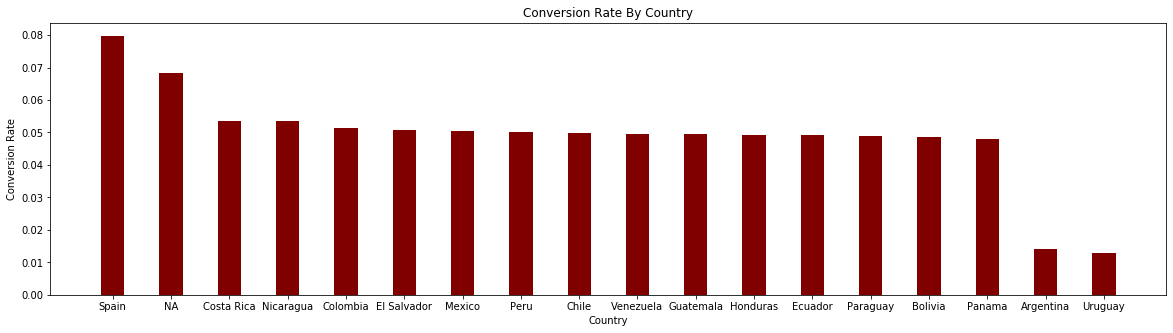

In [16]:
conversion_by_country = pd.DataFrame(data.groupby('country')['conversion'].mean())
conversion_by_country = conversion_by_country.reset_index()
conversion_by_country = conversion_by_country.sort_values(by=['conversion'],ascending = False)

fig = plt.figure(figsize = (20, 5)) 
  
# creating the bar plot 
plt.bar(conversion_by_country['country'], conversion_by_country['conversion'], color ='maroon',  
        width = 0.4) 
  
plt.xlabel('Country') 
plt.ylabel('Conversion Rate') 
plt.title('Conversion Rate By Country') 
plt.show()

#### Conversion Rate by Group

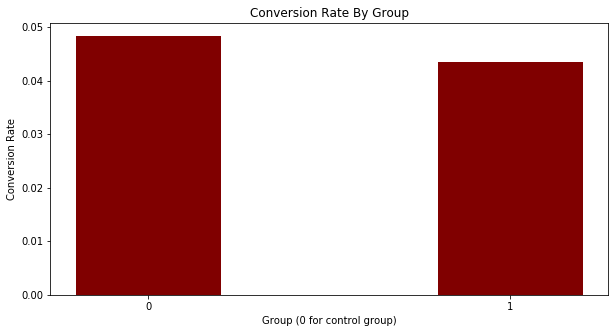

In [38]:
conversion_by_group = pd.DataFrame(data[data.country != 'Spain'].groupby('test')['conversion'].mean())
conversion_by_group = conversion_by_group.reset_index()
conversion_by_group = conversion_by_group.sort_values(by=['conversion'],ascending = False)
conversion_by_group['test'] = conversion_by_group['test'].astype('str')

fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(conversion_by_group['test'], conversion_by_group['conversion'], color ='maroon',  
        width = 0.4) 
  
plt.xlabel('Group (0 for control group)') 
plt.ylabel('Conversion Rate') 
plt.title('Conversion Rate By Group') 
plt.show()

#### Conversion Rate per Group by Date

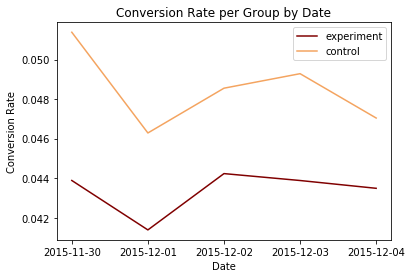

In [39]:
conversion_by_date = pd.DataFrame(data[data.country != 'Spain'].groupby(['date','test'])['conversion'].mean())
conversion_by_date = conversion_by_date.reset_index()

plt.plot(conversion_by_date[conversion_by_date.test==1].date, conversion_by_date[conversion_by_date.test==1].conversion,\
         color ='maroon',label = "experiment", )
plt.plot(conversion_by_date[conversion_by_date.test==0].date, conversion_by_date[conversion_by_date.test==0].conversion,\
         color = 'sandybrown',label = "control")
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate per Group by Date')
plt.legend()
plt.show()

#### Group Size

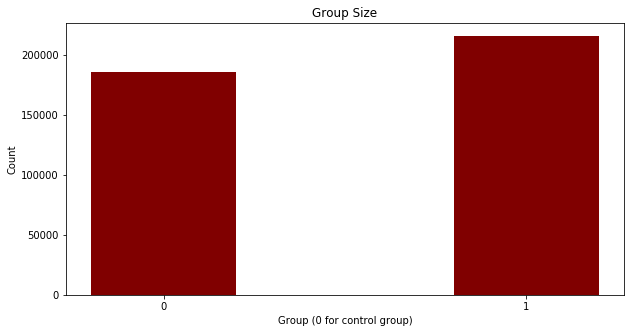

In [40]:
df = pd.DataFrame(data[data.country != 'Spain'].groupby(['test'])['user_id'].count()).reset_index()
df['test'] = df['test'].astype('str')
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(df['test'], df['user_id'], color ='maroon',  
        width = 0.4) 
  
plt.xlabel('Group (0 for control group)') 
plt.ylabel('Count') 
plt.title('Group Size') 
plt.show()

#### Feature Distribution by Group

In [41]:
def visual(df,feature):
    df = pd.DataFrame(data[data.country != 'Spain'].groupby([feature,'test'])['user_id'].count()).reset_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(df[feature].unique()))
    bar_width = 0.4
    b1 = ax.bar(x, df.loc[df['test'] == 0, 'user_id'],
            width=bar_width, color = 'sandybrown',label = 'Control')
    b2 = ax.bar(x + bar_width, df.loc[df['test'] == 1, 'user_id'],
            width=bar_width, color = 'maroon', label = 'Experiment')

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(df[feature].unique())
    ax.legend()

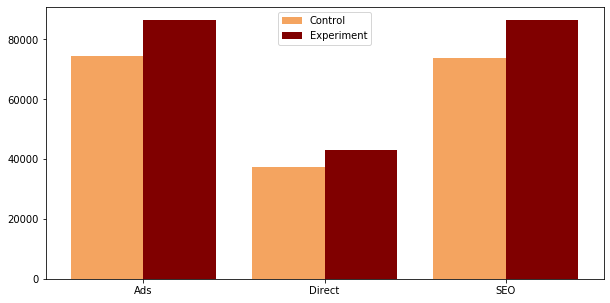

In [42]:
visual(df,'source')

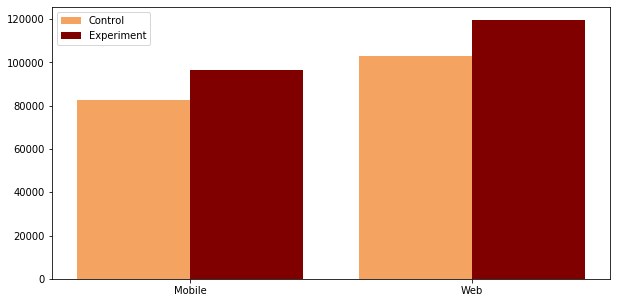

In [43]:
visual(df,'device')

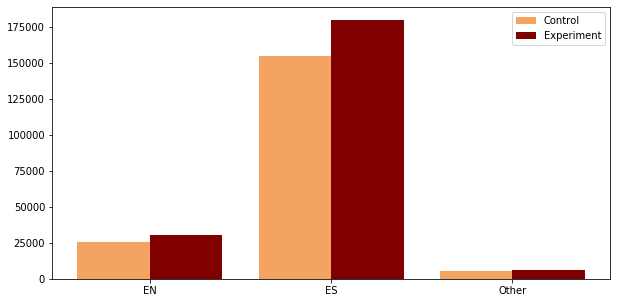

In [44]:
visual(df,'browser_language')

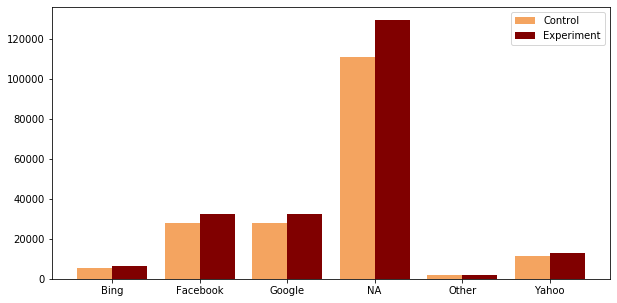

In [45]:
visual(df,'ads_channel')

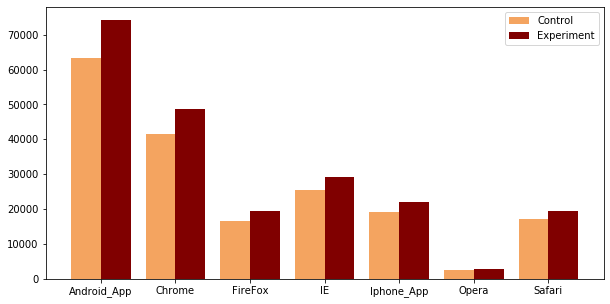

In [46]:
visual(df,'browser')

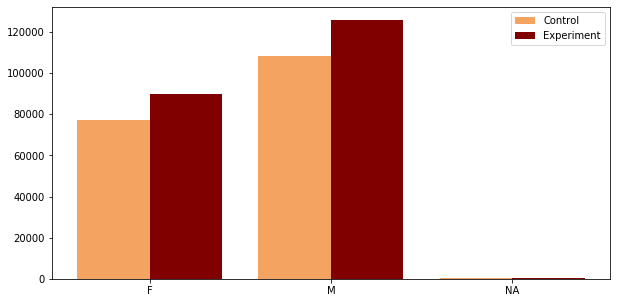

In [47]:
visual(df,'sex')

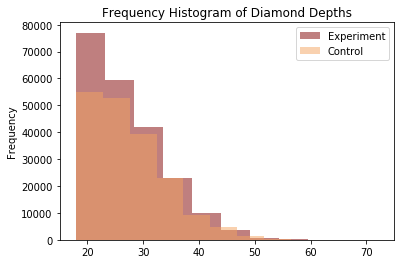

In [48]:
x1 = data[data.country != 'Spain'].loc[data.test==1, 'age']
x2 = data[data.country != 'Spain'].loc[data.test==0, 'age']

kwargs = dict(alpha=0.5, bins=10)

plt.hist(x1, **kwargs, color='maroon', label='Experiment')
plt.hist(x2, **kwargs, color='sandybrown', label='Control')
plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
plt.xlim(15,75)
plt.legend();

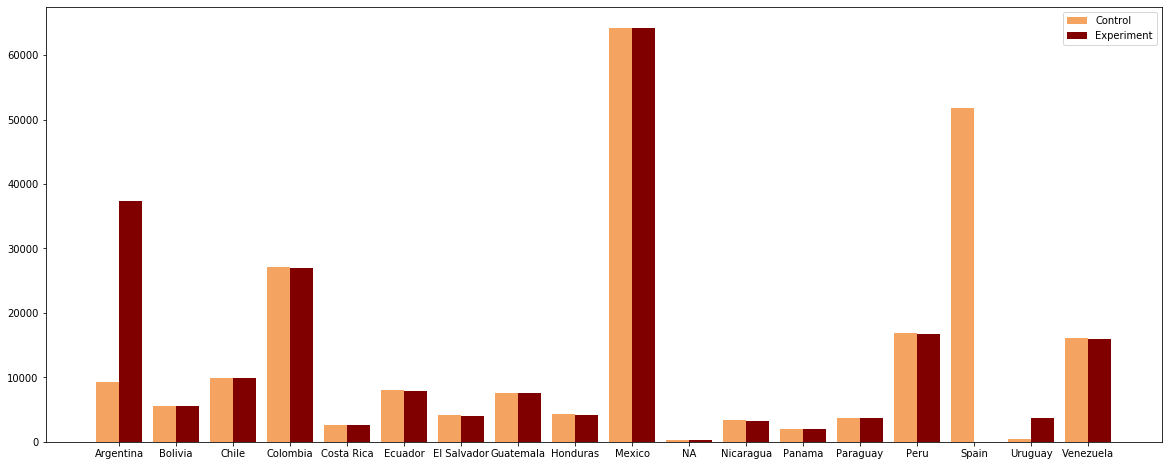

In [50]:
df = pd.DataFrame(data.groupby(['country','test'])['user_id'].count()).reset_index()
df.loc[-1] = ['Spain', 1, 0]
df.index = df.index + 1
df = df.sort_index()
df = df.sort_values(by=['country'],ascending = True)

fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(len(df['country'].unique()))
bar_width = 0.4
b1 = ax.bar(x, df.loc[df['test'] == 0, 'user_id'],
            width=bar_width, color = 'sandybrown',label = 'Control')
b2 = ax.bar(x + bar_width, df.loc[df['test'] == 1, 'user_id'],
            width=bar_width, color = 'maroon', label = 'Experiment')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(df['country'].unique())
ax.legend()

Main Take Away:

According to the descriptive analysis, I found that:

1. Spain-based users have a much higher conversion rate than any other Spanish-speaking country. Argentina and Uruguay have obviously lower conversion rates than other countries.

2. The conversion rate of control group is constantly higher than that of the experiment group.

3. For the experiment group, we can't see a signicant increase in the conversion rate over the days.

4. The experiment group and control group share same distribution in almost all features, except country.


### Question One: Confirm that the test is actually negative.

This is a t-test problem: to test that the average conversion rate of control group is significantly higher than that of experimen group.

Especially, our target customers for this A/B test is Spanish-speaking countries excluding Spain. It is important to exclude Spain from the control group cases.

In [29]:
rp.ttest(group1= data['conversion'][(data['test'] == 0)&(data['country'] != 'Spain')], group1_name= "Control",
         group2= data['conversion'][data['test'] == 1], group2_name= "Experiment")


(     Variable         N      Mean        SD        SE  95% Conf.  Interval
 0     Control  185556.0  0.048330  0.214464  0.000498   0.047355  0.049306
 1  Experiment  215983.0  0.043425  0.203812  0.000439   0.042565  0.044284
 2    combined  401539.0  0.045692  0.208816  0.000330   0.045046  0.046338,
                      Independent t-test      results
 0  Difference (Control - Experiment) =        0.0049
 1                 Degrees of freedom =   401537.0000
 2                                  t =        7.4225
 3              Two side test p value =        0.0000
 4             Difference < 0 p value =        1.0000
 5             Difference > 0 p value =        0.0000
 6                          Cohen's d =        0.0235
 7                          Hedge's g =        0.0235
 8                      Glass's delta =        0.0229
 9                                  r =        0.0117)

According to the t-test result above, the conversion rate of control group (4.8%) is significantly higher than that of experiment group (4.3%) at 5% level, which means that the test is actually negative. 

It appears that the old version of the site with just one translation across Spain and LatAm performs better.

### Question Two: Explain why that might be happening.

Although the t-test result confirmed that the localized translation performed worse, it didn't truely mean that the localized translation was not a good solution.

According to the EDA above, I found that the experiment may have sample selection bias problem - experiment group had much more users from Argentina and Uruguay than conrol group, which can influence the reliabilty of the statistical result.

We should make sure that the samples in control and experiment group are ramdomly selected and share the same distribution of features.

Furthermore, we only have 5-day observation window, which can also influence the result analysis. It will be better to collect more data in a wider date range to decide whether the localized translation works.

In [30]:
result = pd.DataFrame(columns = ['country', 'p_value','conversion_rate_experiment','conversion_rate_control'])
country = []
p_value = []
conversion_rate_experiment= []
conversion_rate_control = []

list_ = data.country.unique().tolist()
list_.remove('Spain')
for i in list_:
    des, res = rp.ttest(group1= data['conversion'][(data['test'] == 0)&(data['country'] == i)], group1_name= "Control",
         group2= data['conversion'][(data['test'] == 1)&(data['country'] == i)], group2_name= "Experiment")
    country.append(i)
    p_value.append(res.iloc[3,1])
    conversion_rate_experiment.append(des.iloc[1,2])
    conversion_rate_control.append(des.iloc[0,2])

result['country'] = country
result['p_value'] = p_value
result['conversion_rate_experiment'] = conversion_rate_experiment
result['conversion_rate_control'] = conversion_rate_control
result

,country,p_value,conversion_rate_experiment,conversion_rate_control
0,Mexico,0.1655,0.051186,0.049495
1,Venezuela,0.5737,0.048978,0.050344
2,Bolivia,0.7189,0.047901,0.049369
3,Colombia,0.4237,0.050571,0.052089
4,Uruguay,0.8828,0.012907,0.012048
5,El Salvador,0.2483,0.047947,0.053554
6,Nicaragua,0.7804,0.054177,0.052647
7,Peru,0.7719,0.050604,0.049914
8,Costa Rica,0.6879,0.054738,0.052256
9,Chile,0.3029,0.051295,0.048107


#### Omit cases from Argentina and Uruguay to check the effect of localized translation

In [52]:
df = data[(data.country != 'Spain')&(data.country != 'Argentina')&(data.country != 'Uruguay')]
rp.ttest(group1= df['conversion'][(df['test'] == 0)], group1_name= "Control",
         group2= df['conversion'][df['test'] == 1], group2_name= "Experiment")


(     Variable         N      Mean        SD        SE  95% Conf.  Interval
 0     Control  175785.0  0.050186  0.218330  0.000521   0.049166  0.051207
 1  Experiment  174887.0  0.050421  0.218813  0.000523   0.049396  0.051447
 2    combined  350672.0  0.050303  0.218571  0.000369   0.049580  0.051027,
                      Independent t-test      results
 0  Difference (Control - Experiment) =       -0.0002
 1                 Degrees of freedom =   350670.0000
 2                                  t =       -0.3181
 3              Two side test p value =        0.7504
 4             Difference < 0 p value =        0.3752
 5             Difference > 0 p value =        0.6248
 6                          Cohen's d =       -0.0011
 7                          Hedge's g =       -0.0011
 8                      Glass's delta =       -0.0011
 9                                  r =        0.0005)

According to the t-test result above, there was no significant difference in the performance of localized translation and non-localized translation by controling the country (p-values are all greater than 0.1), which means that although localized translation didn't significantly increase conversion rate, it didn't decrease the conversion rate either.

Furthermore, when I omitted the cases from Argentina and Uruguay and recalculate the effect of AB test, I found that the p-value was greater than 0.1, which meant that there was no significant difference in control and experiment group when deleting the biased samples.

Thus, we are confident to say that we encountered a sample selection bias in this AB test case. 

Our next action is to create an algorithm to automatically detect such sample selection bias before we make a conclusion.

### Question Three: Design an algorithm

#### Quick Check Solution

Hypothesis: 

If the sample is randomly selected, then there should be no siginicant relationship between features and experiment/control group.

In other words, for the categorical variables, the p-value of Chi-square test is not significant, and  for the numeric variables, the p-values of t-test is not siginicant either. Thus, we can say that samples are selected randomly under the features.

This quick check solution can output the features with their p-values which show significant/insignificant relation with experiment/control group. If the p-value is lower than 0.1, we should be aware of the potential risk of selection bias.

In [31]:
df = data[data.country != 'Spain']
df = df.drop('date',axis=1)
columns_cat = df.select_dtypes(include='object').columns.tolist()
columns_num = df.select_dtypes(include='float64').columns.tolist()

detect_result = pd.DataFrame(columns = ['Feature', 'p_value'])

feature = []
p_value = []

for i in columns_cat:
    feature.append(i)
    table = pd.pivot_table(df, values='user_id', index=[i],
                    columns=['test'], aggfunc=lambda x: len(x.unique())).reset_index()

    list_1 = []
    list_all = []

    for i in range(table.shape[0]):
        list_1.append(table.iloc[i,1])
        list_1.append(table.iloc[i,2])
        list_all.append(list_1)
        list_1 = []
    
    stat, p, dof, expected = chi2_contingency(list_all)
    p_value.append(p)

for i in columns_num:
    des, res = rp.ttest(group1= df['age'][(data['test'] == 0)], group1_name= "Control",
         group2= data['age'][data['test'] == 1], group2_name= "Experiment")
    feature.append(i)
    p_value.append(res.iloc[3,1])

detect_result['Feature'] = feature
detect_result['p_value'] = p_value
detect_result = detect_result.sort_values('p_value')
detect_result

,Feature,p_value
6,country,0.000000
5,sex,0.003765
4,browser,0.020616
7,age,0.192700
1,device,0.264464
0,source,0.340499
2,browser_language,0.539991
3,ads_channel,0.772381


According to the output table above, marketing team should pay attention to the selection bias caused by country which is the top risky feature in the table.

#### Official Solution

Hypothesis:

If samples in the experiment and control group are randomly selected, then the cases distribution in each node of a decision tree should be balanced, which means that the experiment and control group cases are almost evenly in such dimension.

Thus, I create a decision tree with 'test' as target, to check the distribution of the experiment and control group in each node.

In [32]:
model_dta = data[data.country != 'Spain']
model_dta = model_dta[['test','source','device','browser_language','ads_channel','browser','sex','age','country']]
columns = model_dta.select_dtypes(include='object').columns.tolist()
model_dta = pd.get_dummies(model_dta, columns = columns)


In [33]:
model_dta.head()

,test,age,source_Ads,source_Direct,source_SEO,device_Mobile,device_Web,browser_language_EN,browser_language_ES,browser_language_Other,...,country_Guatemala,country_Honduras,country_Mexico,country_NA,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Uruguay,country_Venezuela
1,1,21.0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,22.0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,1,19.0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,1,22.0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,0,35.0,0,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


(array([185556.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 215983.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

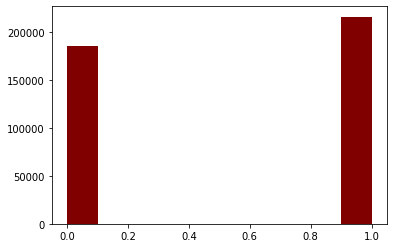

In [34]:
plt.hist(model_dta.test, color = 'maroon')

In [35]:
X = model_dta.iloc[:,1:]
y = model_dta.test.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22)

dtree = DecisionTreeClassifier(max_depth=4, random_state=22)
dtree.fit(X_train, y_train)
yhat = dtree.predict(X_test)

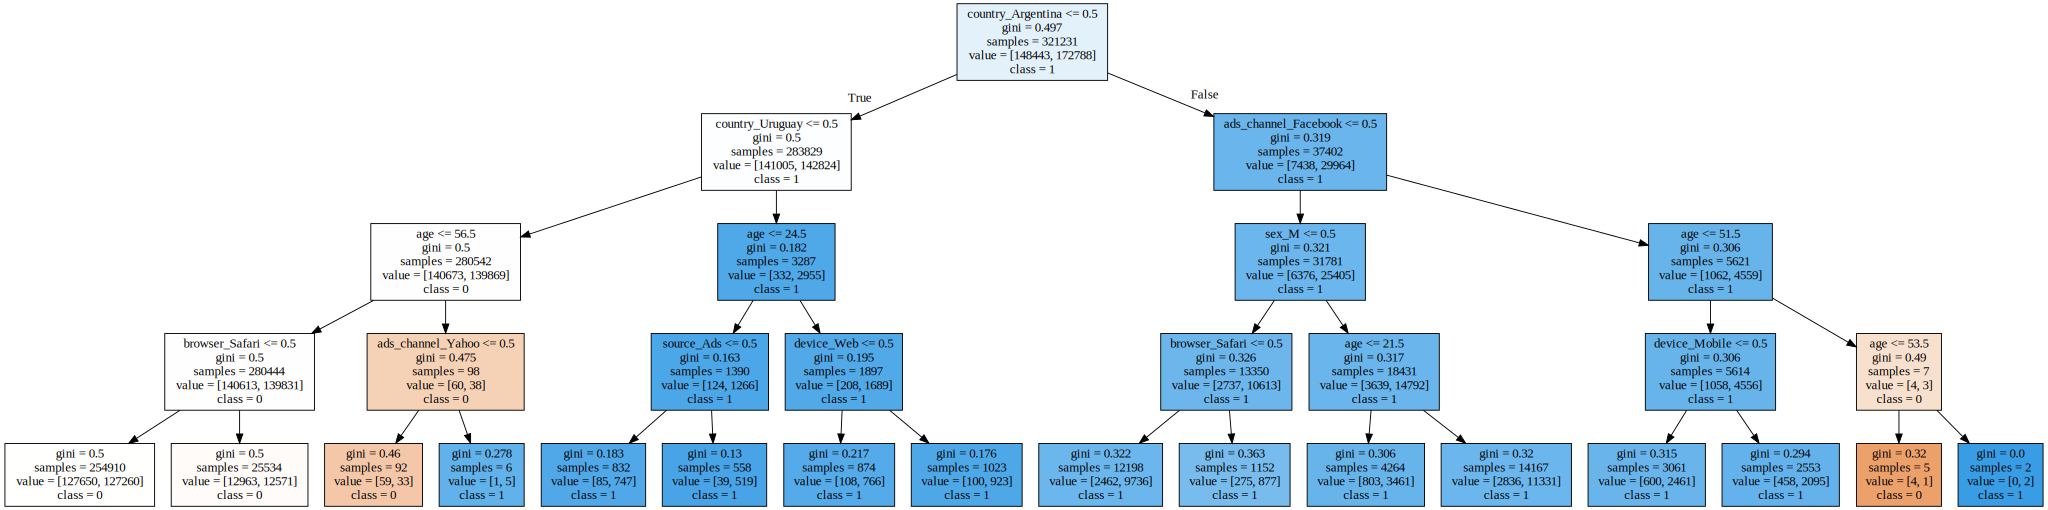

In [36]:
# DOT data
features = model_dta.columns.tolist()[1:]
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names=features,  
                                class_names=['0','1'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

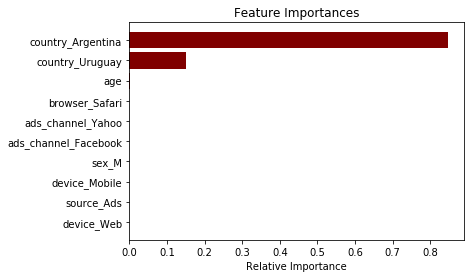

In [37]:
importances = dtree.feature_importances_
indices = np.argsort(importances)
num_features = 10 

plt.title('Feature Importances')
plt.barh(range(num_features), importances[indices[-num_features:]], color = 'maroon', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

According to the tree plot and feature importance plot above, I found that most cases are labeled as experimental group in the nodes 'country_Argentina' and 'country_Uruguay', which means that 'country_Argentina' and 'country_Uruguay' can influence the group division, causing the selection bias.